# Sensitivity to the number of years validated on: 

In [28]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [30]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [31]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [32]:
def plot_lagged_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin):

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
    
    return 

In [33]:
def plot_monthly_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
#    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
    
#    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
    return 

In [23]:
ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
ntrunc_sic = 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0
lags = [0,1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
yrend = 1650

nyrs_valid = 200

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/latcutoff/'

lat_cutoff_dict = {'tas':50,'psl':50,'zg':50,'tos':50,'sit':50,'sic':50}

In [44]:
latcutoff_list = [40,50]
rmse_sic_is = np.zeros((len(latcutoff_list),len(lags)))
rmse_sic_os = np.zeros((len(latcutoff_list),len(lags)))

for n,latcutoff in enumerate(latcutoff_list):
    print('Working on '+(" + ").join(limvars))
    var = limvars[0]
    var_names = (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)
    
    folder = 'last_millennium/'
    filename_is = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_latcutoff_'+
                   str(latcutoff)+'_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl')
    filename_os = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_latcutoff_'+
                   str(latcutoff)+'_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl')

    print('Loading '+data_dir+folder+filename_is)

    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    rmse_sic_is[n,:] = forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][:]
    rmse_sic_os[n,:] = forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][:]

Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/latcutoff/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_latcutoff_40_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl
Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/latcutoff/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_latcutoff_50_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl


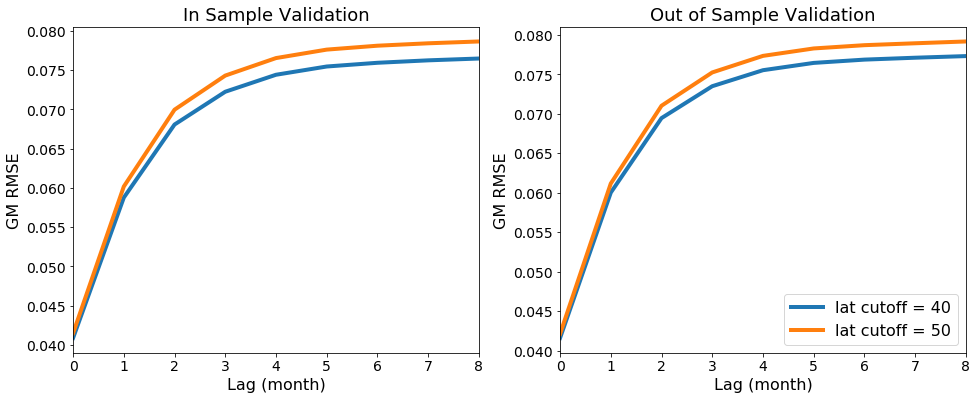

In [55]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
ax=axs.flatten()

ax[0].plot(rmse_sic_is[0,:], label='lat cutoff = 40', linewidth=4)
ax[1].plot(rmse_sic_os[0,:], label='lat cutoff = 40', linewidth=4)

ax[0].plot(rmse_sic_is[1,:], label='lat cutoff = 50', linewidth=4)
ax[1].plot(rmse_sic_os[1,:], label='lat cutoff = 50', linewidth=4)
    
ax[0].set_xlim(0,8)
#ax[0].set_ylim(0.059,0.09)
#ax[0].legend(bbox_toanchor=[1,1],fontsize=14)
ax[0].set_ylabel('GM RMSE', fontsize=16)
ax[0].set_xlabel('Lag (month)', fontsize=16)
#ax[0].set_xticklabels(nyrs_valid, fontsize=14)
ax[0].set_title('In Sample Validation', fontsize=18)
ax[0].tick_params(labelsize=14)


ax[1].set_xlim(0,8)
#ax[1].set_ylim(0.059,0.09)
ax[1].legend(loc='lower right',fontsize=16)
ax[1].set_ylabel('GM RMSE', fontsize=16)
ax[1].set_xlabel('Lag (month)', fontsize=16)
#ax[1].set_xticklabels(nyrs_valid, fontsize=14)
ax[1].set_title('Out of Sample Validation', fontsize=18)
ax[1].tick_params(labelsize=14)

## Updated experiments: 

In [56]:
rmse_sic_50 = np.zeros((len(latcutoff_list),len(lags)))
rmse_sic_4050 = np.zeros((len(latcutoff_list),len(lags)))

    
folder = 'last_millennium/'
filename_50 = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_'+
               'tas50L50_psl50L50_zg50L50_tos50L50_sit50L50_sic50L50_20211202.pkl')
filename_40 = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_'+
               'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_4050 = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_'+
               'tas50L40_psl50L40_zg50L40_tos50L40_sit50L50_sic50L50_20211202.pkl')
filename_3050 = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_'+
               'tas50L30_psl50L30_zg50L30_tos50L30_sit50L50_sic50L50_20211202.pkl')

print('Loading '+data_dir+folder+filename_is)

experiment_50 =  pickle.load(open(data_dir+folder+filename_50, 'rb'))
experiment_40 =  pickle.load(open(data_dir+folder+filename_40, 'rb'))
experiment_4050 =  pickle.load(open(data_dir+folder+filename_4050, 'rb'))
experiment_3050 =  pickle.load(open(data_dir+folder+filename_3050, 'rb'))

LIMd_50 = experiment_50['LIMd']
exp_setup_50 = experiment_50['forecast']['exp_setup']
forecast_50 = experiment_50['forecast']
forecast_validation_lags_50 = experiment_50['forecast_validation_lags']
ar1cast_lags_50 = experiment_50['ar1cast_lags']

LIMd_40 = experiment_40['LIMd']
exp_setup_40 = experiment_40['forecast']['exp_setup']
forecast_40 = experiment_40['forecast']
forecast_validation_lags_40 = experiment_40['forecast_validation_lags']
ar1cast_lags_40 = experiment_40['ar1cast_lags']

exp_setup_4050 = experiment_4050['forecast']['exp_setup']
forecast_4050 = experiment_4050['forecast']
forecast_validation_lags_4050 = experiment_4050['forecast_validation_lags']
ar1cast_lags_4050 = experiment_4050['ar1cast_lags']

exp_setup_3050 = experiment_3050['forecast']['exp_setup']
forecast_3050 = experiment_3050['forecast']
forecast_validation_lags_3050 = experiment_3050['forecast_validation_lags']
ar1cast_lags_3050 = experiment_3050['ar1cast_lags']

[tcmip_50, vcmip_50, valid_yrs_str_50, texp_50, 
 vexp_50, tmod_50, vmod_50, wt_addin_50, tr_addin_50] = get_title_strings(var,exp_setup_50,forecast_50)
[tcmip_4050, vcmip_4050, valid_yrs_str_4050, texp_4050, 
 vexp_4050, tmod_4050, vmod_4050, wt_addin_4050, tr_addin_4050] = get_title_strings(var,exp_setup_4050,
                                                                                    forecast_4050)
rmse_sic_50[n,:] = forecast_validation_lags_50['validation_stats_lags']['sic']['gm_rmse'][:]
rmse_sic_4050[n,:] = forecast_validation_lags_4050['validation_stats_lags']['sic']['gm_rmse'][:]

Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/latcutoff/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_0851_1050_latcutoff_50_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl


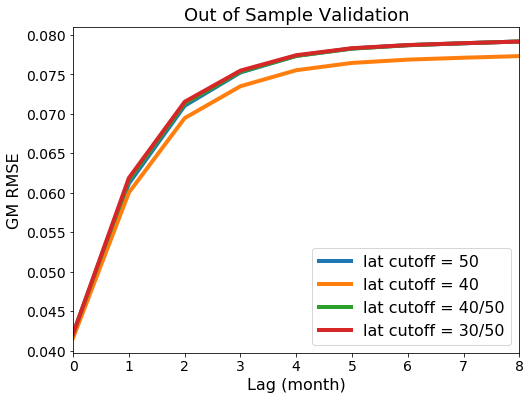

In [63]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(forecast_validation_lags_50['validation_stats_lags']['sic']['gm_rmse'][:], 
        label='lat cutoff = 50', linewidth=4)
ax.plot(forecast_validation_lags_40['validation_stats_lags']['sic']['gm_rmse'][:], 
        label='lat cutoff = 40', linewidth=4)
ax.plot(forecast_validation_lags_4050['validation_stats_lags']['sic']['gm_rmse'][:], 
        label='lat cutoff = 40/50', linewidth=4)
ax.plot(forecast_validation_lags_3050['validation_stats_lags']['sic']['gm_rmse'][:], 
        label='lat cutoff = 30/50', linewidth=4)

# ax.plot(rmse_sic_os[0,:], label='lat cutoff = 40 OG', linewidth=4)
    
ax.set_xlim(0,8)
#ax[0].set_ylim(0.059,0.09)
#ax[0].legend(bbox_to_anchor=[1,1],fontsize=14)
ax.set_ylabel('GM RMSE', fontsize=16)
ax.set_xlabel('Lag (month)', fontsize=16)
#ax[0].set_xticklabels(nyrs_valid, fontsize=14)
ax.set_title('Out of Sample Validation', fontsize=18)
ax.tick_params(labelsize=14)
ax.legend(loc='lower right', fontsize=16)